In [61]:
import polars as pl
import sys

sys.path.append("../..")
from src.utils import *
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from typing import List, Tuple
import json

Integer = int
Grid = Tuple[Tuple[Integer]]

In [62]:
clean_summary_path = "../../data/clean_summary_data.csv"
clean_summary_incomplete_path = "../../data/clean_summary_data_incomplete.csv"
clean_data_path = "../../data/clean_data.csv"
clean_incomplete_path = "../../data/clean_data_incomplete.csv"
clean_errors_path = "../../data/clean_errors.csv"
clean_errors_incomplete_path = "../../data/clean_errors_incomplete.csv"

df_summary = pl.read_csv(clean_summary_path)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path)
df_all = pl.read_csv(clean_data_path)
df_all_incomplete = pl.read_csv(clean_incomplete_path)
df_errors = pl.read_csv(clean_errors_path)
df_errors_incomplete = pl.read_csv(clean_errors_incomplete_path)

In [63]:
ARC_eval_path = "../../../ARC/data/evaluation"
ARC_training_path = "../../../ARC/data/training"

Note: if ever I want to recover the original files, I can simply get the files from the arc_project repo and rerun the "clean-data-files.ipynb" pipeline.


The ARC .csv files should also be regenerated according to updates.


# 79fb03f4

No participant got this one correct under any interpretation so I'll just leave it as is.

The website will show the original version (revert back and update).


# b4a43f3b

For this task, I'll update the website so that the task examples are the latest versions. Participants that match the latest test output are scored correct and any further attempts (if any) are discarded.


In [64]:
task_name = "b4a43f3b.json"
task_json = json.load(open(f"{ARC_eval_path}/{task_name}"))
correct_test_output = grid2str(task_json["test"][0]["output"])

In [65]:
def get_incorrectly_scored(df, task_name, correct_test_output):
    return (
        df.filter(
            (pl.col("task_name") == task_name)
            & (pl.col("test_output_grid") == correct_test_output)
            & ~pl.col("solved")
        )
        .group_by("joint_id_task")
        .agg(
            pl.min("attempt_number"),
            pl.first("first_written_solution"),
            pl.first("last_written_solution"),
        )
    )

In [66]:
incorrectly_scored = get_incorrectly_scored(df_summary, task_name, correct_test_output)
incorrectly_scored_incomplete = get_incorrectly_scored(
    df_summary_incomplete, task_name, correct_test_output
)

In [67]:
def update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, correct_test_output
):
    for row in incorrectly_scored.iter_rows(named=True):
        joint_id_task = row["joint_id_task"]
        attempt_number = row["attempt_number"]

        # update to solved
        df_summary = df_summary.with_columns(
            pl.when(
                (pl.col("joint_id_task") == joint_id_task)
                & (pl.col("attempt_number") == attempt_number)
            )
            .then(True)
            .otherwise(pl.col("solved"))
            .alias("solved"),
        )
        max_action = (
            df_all.filter(
                (pl.col("joint_id_task") == joint_id_task)
                & (pl.col("attempt_number") == attempt_number)
            )
            .select(pl.max("num_actions"))
            .item()
        )
        df_all = df_all.with_columns(
            pl.when(
                (pl.col("joint_id_task") == joint_id_task)
                & (pl.col("attempt_number") == attempt_number)
                & (pl.col("num_actions") == max_action)
            )
            .then(True)
            .otherwise(pl.col("solved"))
            .alias("solved")
        )

        # check if attempt number 1 to switch written solution to first one
        if attempt_number == 1:
            df_summary = df_summary.with_columns(
                pl.when(
                    (pl.col("joint_id_task") == joint_id_task)
                    & (pl.col("attempt_number") == attempt_number)
                )
                .then(pl.col("first_written_solution"))
                .otherwise(pl.col("last_written_solution"))
                .alias("last_written_solution"),
            )
            df_all = df_all.with_columns(
                pl.when(
                    (pl.col("joint_id_task") == joint_id_task)
                    & (pl.col("attempt_number") == attempt_number)
                )
                .then(pl.col("first_written_solution"))
                .otherwise(pl.col("last_written_solution"))
                .alias("last_written_solution"),
            )

        # remove correct grid from errors
        df_errors = df_errors.filter(
            ~(
                (pl.col("test_output_grid") == correct_test_output)
                & (pl.col("task_name") == task_name)
            )
        )

        # remove subsequent submissions from errors
        other_submissions = (
            (
                df_summary.filter(
                    (
                        (pl.col("joint_id_task") == joint_id_task)
                        & (pl.col("attempt_number") > attempt_number)
                    )
                )
            )
            .group_by("test_output_grid")
            .agg(pl.len().alias("count"))
        )
        other_submission_errors = df_errors.filter(
            pl.col("test_output_grid").is_in(
                other_submissions.select("test_output_grid")
            )
            & (pl.col("task_name") == task_name)
        )
        other_submission_errors = other_submission_errors.join(
            other_submissions, on="test_output_grid"
        )
        other_submission_errors = other_submission_errors.with_columns(
            pl.col("count") - pl.col("count_right")
        ).drop("count_right")
        other_submission_errors = other_submission_errors.filter(pl.col("count") > 0)
        df_errors = df_errors.filter(
            ~(
                pl.col("test_output_grid").is_in(
                    other_submissions.select("test_output_grid")
                )
                & (pl.col("task_name") == task_name)
            )
        ).vstack(other_submission_errors)

        # remove further attempts
        df_summary = df_summary.filter(
            ~(
                (pl.col("joint_id_task") == joint_id_task)
                & (pl.col("attempt_number") > attempt_number)
            )
        )
        df_all = df_all.filter(
            ~(
                (pl.col("joint_id_task") == joint_id_task)
                & (pl.col("attempt_number") > attempt_number)
            )
        )

    return df_summary, df_all, df_errors

In [68]:
# Run for complete data
df_summary, df_all, df_errors = update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, correct_test_output
)

# Run for incomplete data
df_summary_incomplete, df_all_incomplete, df_errors_incomplete = update_scoring(
    df_summary_incomplete,
    df_all_incomplete,
    df_errors_incomplete,
    incorrectly_scored_incomplete,
    task_name,
    correct_test_output,
)

# e6de6e8f

For this task, leave to current state. Participants were given incorrect training examples but the rule could still be inferred.

This task should be excluded from accuracy and IRT model.


# 423a55dc

Update to latest version and manually score participants


In [69]:
task_name = "423a55dc.json"
task_json = json.load(open(f"{ARC_eval_path}/{task_name}"))
correct_test_output = grid2str(task_json["test"][0]["output"])

In [70]:
incorrectly_scored = get_incorrectly_scored(df_summary, task_name, correct_test_output)
incorrectly_scored_incomplete = get_incorrectly_scored(
    df_summary_incomplete, task_name, correct_test_output
)

In [71]:
# Run for complete data
df_summary, df_all, df_errors = update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, correct_test_output
)

# Run for incomplete data
df_summary_incomplete, df_all_incomplete, df_errors_incomplete = update_scoring(
    df_summary_incomplete,
    df_all_incomplete,
    df_errors_incomplete,
    incorrectly_scored_incomplete,
    task_name,
    correct_test_output,
)

# 58e15b12

Update to latest version and manually score participants. Two participants got it right accidentally, score as wrong and discard as incomplete attempt data (clear).


In [72]:
task_name = "58e15b12.json"
task_json = json.load(open(f"{ARC_eval_path}/{task_name}"))
correct_test_output = grid2str(task_json["test"][0]["output"])

In [73]:
wrong_but_right = df_summary.filter(
    ((pl.col("task_name") == task_name) & pl.col("solved"))
)
df_summary = df_summary.filter(~((pl.col("task_name") == task_name) & pl.col("solved")))

In [74]:
df_all = df_all.filter(
    ~pl.col("joint_id_task").is_in(wrong_but_right.select("joint_id_task"))
)

In [75]:
incorrectly_scored = get_incorrectly_scored(df_summary, task_name, correct_test_output)
incorrectly_scored_incomplete = get_incorrectly_scored(
    df_summary_incomplete, task_name, correct_test_output
)

In [76]:
# Run for complete data
df_summary, df_all, df_errors = update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, correct_test_output
)


# Run for incomplete data
df_summary_incomplete, df_all_incomplete, df_errors_incomplete = update_scoring(
    df_summary_incomplete,
    df_all_incomplete,
    df_errors_incomplete,
    incorrectly_scored_incomplete,
    task_name,
    correct_test_output,
)

# 20818e16

Rule could be inferred so update to new.


# 310f3251

Revert to previous test example to match people's solutions. Accept alternative solution as well.

-- webpage should mention this


In [77]:
task_name = "310f3251.json"
task_json = {
    "train": [
        {
            "input": [[0, 0], [0, 7]],
            "output": [
                [2, 0, 2, 0, 2, 0],
                [0, 7, 0, 7, 0, 7],
                [2, 0, 2, 0, 2, 0],
                [0, 7, 0, 7, 0, 7],
                [2, 0, 2, 0, 2, 0],
                [0, 7, 0, 7, 0, 7],
            ],
        },
        {
            "input": [[0, 0, 0], [0, 0, 6], [6, 0, 0]],
            "output": [
                [0, 2, 0, 0, 2, 0, 0, 2, 0],
                [0, 0, 6, 0, 0, 6, 0, 0, 6],
                [6, 0, 0, 6, 0, 0, 6, 0, 0],
                [0, 2, 0, 0, 2, 0, 0, 2, 0],
                [0, 0, 6, 0, 0, 6, 0, 0, 6],
                [6, 0, 0, 6, 0, 0, 6, 0, 0],
                [0, 2, 0, 0, 2, 0, 0, 2, 0],
                [0, 0, 6, 0, 0, 6, 0, 0, 6],
                [6, 0, 0, 6, 0, 0, 6, 0, 0],
            ],
        },
        {
            "input": [
                [0, 0, 0, 0, 0],
                [0, 8, 0, 0, 0],
                [0, 8, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            "output": [
                [2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                [2, 8, 0, 0, 0, 2, 8, 0, 0, 0, 2, 8, 0, 0, 0],
                [0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                [2, 8, 0, 0, 0, 2, 8, 0, 0, 0, 2, 8, 0, 0, 0],
                [0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                [2, 8, 0, 0, 0, 2, 8, 0, 0, 0, 2, 8, 0, 0, 0],
                [0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            ],
        },
        {
            "input": [[0, 0, 0, 0], [0, 0, 5, 0], [0, 0, 0, 0], [0, 5, 0, 0]],
            "output": [
                [0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0],
                [0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0],
                [2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0],
                [0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0],
                [0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0],
                [0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0],
                [2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0],
                [0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0],
                [0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0],
                [0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0],
                [2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0],
                [0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0],
            ],
        },
    ],
    "test": [
        {
            "input": [[0, 0, 4, 0], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 0]],
            "output": [
                [0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
                [4, 2, 0, 0, 4, 2, 0, 0, 4, 2, 0, 0],
                [0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
                [4, 2, 0, 0, 4, 2, 0, 0, 4, 2, 0, 0],
                [0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
                [4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0],
            ],
        }
    ],
}
correct_test_output = grid2str(task_json["test"][0]["output"])

In [78]:
def plot_grid(grid: Grid, ax: plt.Axes = None, title: str = None) -> None:
    """
    Plots a single grid.

    Args:
    grid (Grid): The grid to be plotted.
    ax (plt.Axes, optional): The axes on which to plot. If None, a new figure is created.
    title (str, optional): The title for the plot.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))

    cmap = ListedColormap(
        [
            "#000",
            "#0074D9",
            "#FF4136",
            "#2ECC40",
            "#FFDC00",
            "#AAAAAA",
            "#F012BE",
            "#FF851B",
            "#7FDBFF",
            "#870C25",
        ]
    )
    norm = Normalize(vmin=0, vmax=9)

    ax.imshow(grid, cmap=cmap, norm=norm)
    ax.axis("off")

    if title:
        ax.set_title(title)

    plt.tight_layout()
    if ax is None:
        plt.show()


def format_grid(grid: List[List[int]]) -> Grid:
    """
    grid type casting
    """
    return tuple(tuple(row) for row in grid)


def format_example(example: dict) -> dict:
    """
    example data type
    """
    return {
        "input": format_grid(example["input"]),
        "output": format_grid(example["output"]),
    }

In [79]:
task_alt = [
    format_example(example) for example in task_json["train"] + task_json["test"]
]

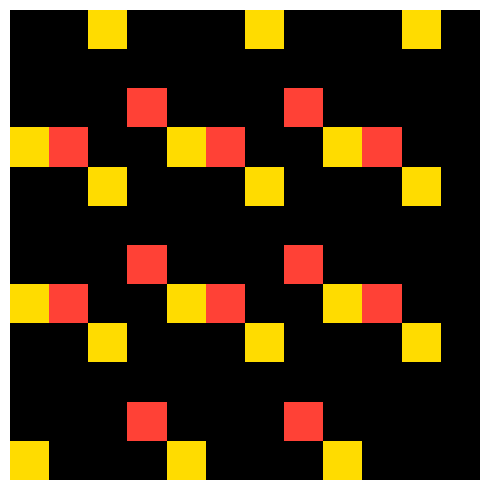

In [80]:
plot_grid(task_alt[-1]["output"])

In [81]:
alt_out = []
for i, row in enumerate(task_alt[-1]["output"]):
    new_row = []
    for j, col in enumerate(row):
        if (i in [2, 6, 10]) & (j == (len(row) - 1)) & (i != 0):
            new_row.append(2)
        elif (i == len(task_alt[-1]["output"]) - 1) & (j in [1, 5, 9]):
            new_row.append(2)
        else:
            new_row.append(col)
    alt_out.append(tuple(new_row))
alt_out = tuple(alt_out)

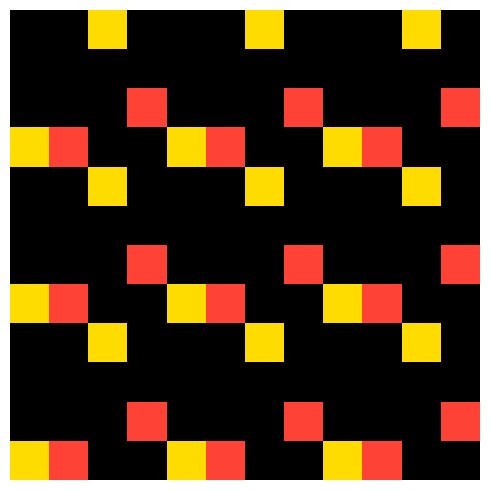

In [82]:
plot_grid(alt_out)

In [83]:
alt_out = grid2str(alt_out)

In [84]:
incorrectly_scored = get_incorrectly_scored(df_summary, task_name, alt_out)
incorrectly_scored_incomplete = get_incorrectly_scored(
    df_summary_incomplete, task_name, alt_out
)

In [85]:
# Run for complete data
df_summary, df_all, df_errors = update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, alt_out
)


# Run for incomplete data
df_summary_incomplete, df_all_incomplete, df_errors_incomplete = update_scoring(
    df_summary_incomplete,
    df_all_incomplete,
    df_errors_incomplete,
    incorrectly_scored_incomplete,
    task_name,
    alt_out,
)

# b230c067

People got correct rule after two tries. Ambiguous rule when only given 2 examples so accept both and keep updated.

-- webpage should mention this.


In [86]:
task_name = "b230c067.json"
task_json = json.load(open(f"{ARC_training_path}/{task_name}"))
task_alt = [
    format_example(example) for example in task_json["train"] + task_json["test"]
]

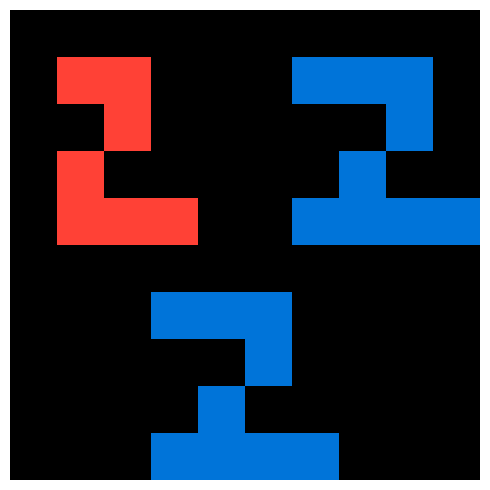

In [87]:
plot_grid(task_alt[-1]["output"])

In [88]:
alt_out = []
for i, row in enumerate(task_alt[-1]["output"]):
    new_row = []
    for j, col in enumerate(row):
        if i < 5 and j > 5 and col == 1:
            new_row.append(2)
        elif col == 2:
            new_row.append(1)
        else:
            new_row.append(col)
    alt_out.append(tuple(new_row))
alt_out = tuple(alt_out)

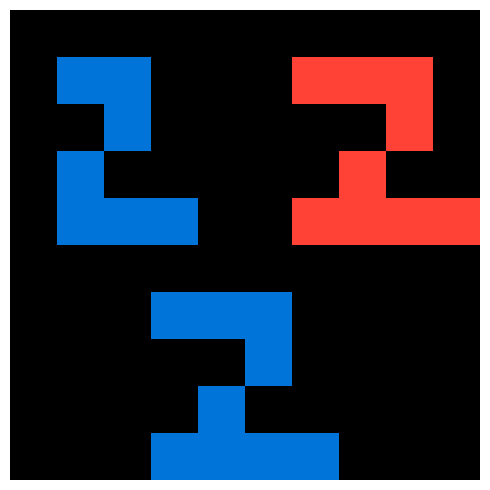

In [89]:
plot_grid(alt_out)

In [90]:
alt_out = grid2str(alt_out)

In [91]:
incorrectly_scored = get_incorrectly_scored(df_summary, task_name, alt_out)
incorrectly_scored_incomplete = get_incorrectly_scored(
    df_summary_incomplete, task_name, alt_out
)

In [92]:
# Run for complete data
df_summary, df_all, df_errors = update_scoring(
    df_summary, df_all, df_errors, incorrectly_scored, task_name, alt_out
)


# Run for incomplete data
df_summary_incomplete, df_all_incomplete, df_errors_incomplete = update_scoring(
    df_summary_incomplete,
    df_all_incomplete,
    df_errors_incomplete,
    incorrectly_scored_incomplete,
    task_name,
    alt_out,
)

In [93]:
# Save updated dataframes back to original files
df_summary.write_csv(clean_summary_path)
df_summary_incomplete.write_csv(clean_summary_incomplete_path)
df_all.write_csv(clean_data_path)
df_all_incomplete.write_csv(clean_incomplete_path)
df_errors.write_csv(clean_errors_path)
df_errors_incomplete.write_csv(clean_errors_incomplete_path)